# Overview

In this notebook I develop the code necessary to prepare raw _Planet_ satellite 
images for the object detection model.The input if is a file/directory path. The file is loaded, clipped to the area of interest provided by the user, and then resized to a size appropriate for labeling by the model. The resized image dimensions are also provided by the user.

## Download Imagery


In [2]:
# Imports here
import os

from google.cloud import storage

# Create the service client.
from googleapiclient.discovery import build
from apiclient.http import MediaIoBaseDownload

In [4]:
# GOOGLE CREDS is different for notebook – change for .py files
GOOGLE_APPLICATION_CREDENTIALS = os.getenv('GOOGLE_APPLICATION_CREDENTIALS')
BUCKET_NAME = os.getenv('BUCKET_NAME')
GEO_FILTER_PATH = os.getenv('GEO_FILTER_PATH')
PATH_PREFIX = os.getenv('PATH_PREFIX')
ORDER_ID = os.getenv('ORDER_ID')
ITEM_TYPE = os.getenv('ITEM_TYPE')
ITEM_ID_PATH = os.getenv('ITEM_ID_PATH')
DL_IMAGE_PATH = os.getenv('DL_IMAGE_PATH')
BAND_ID = os.getenv('BAND_ID')

In [5]:
def download_img(dl_path, id_num):
    gcs_service = build('storage', 'v1')
    if not os.path.exists(os.path.dirname(dl_path)):
        try:
            os.makedirs(os.path.dirname(dl_path))
        except OSError as exc: # Guard against race condition
            if exc.errno != errno.EEXIST:
                raise
    with open(dl_path, 'wb') as f:
      # Download the file from the Google Cloud Storage bucket.
      request = gcs_service.objects().get_media(bucket=BUCKET_NAME,
                                                object=dl_path)
      media = MediaIoBaseDownload(f, request)
      print('Downloading image ', id_num, '...')
      print('Download Progress: ')
      done = False
      while not done:
          prog, done = media.next_chunk()
          print(prog.progress())

    print('Image ', id_num, ' downloaded.')
    return dl_path

In [6]:
dl_path = r'lima/2a2ca315-88af-4c4f-be1d-befdab5ce7fa/PSScene4Band/20161204_181909_0d06_3B_AnalyticMS.tif'
filepath = download_img(dl_path, id_num=0)

Download Progress: 
1.0
Image  0  downloaded.


In [7]:

dl_path[55:-18]

'20161204_181909_0d06'

## Preprocess Imagery


In [8]:
from google.cloud import storage
from skimage.util import view_as_blocks, pad
import math
import numpy as np

from osgeo import gdal, osr, ogr


aoi = r'/content/peru_callao.json'


In [9]:
!pip3 install geojson

In [10]:
import geojson as gj
from osgeo import ogr, osr, gdal

# Enable GDAL/OGR exceptions
gdal.UseExceptions()


# GDAL & OGR memory drivers
GDAL_MEMORY_DRIVER = gdal.GetDriverByName('MEM')
OGR_MEMORY_DRIVER = ogr.GetDriverByName('Memory')


def get_geo_info(ds):
    xoff, a, b, yoff, d, e = ds.GetGeoTransform()

    # Get projection information from source image
    ds_proj = ds.GetProjectionRef()
    ds_srs = osr.SpatialReference(ds_proj)

    # Get the source image's geographic coordinate system (the 'GEOGCS' node of ds_srs)
    geogcs = ds_srs.CloneGeogCS()

    # Set up a transformation between projected coordinates (x, y) & geographic coordinates (lat, lon)
    transform = osr.CoordinateTransformation(ds_srs, geogcs)
    return (xoff, a, b, yoff, d, e), transform


def load_img(img_path):
  '''Returns both the relevant geographic data, and other metadata such as
   cloudcover etc. and the img itself as a numpy array.
  '''
  ds = gdal.Translate('',
                img_path,
                options='-ot Byte -scale minval maxval -of MEM')
  (xoff, a, b, yoff, d, e), transform = get_geo_info(ds)
  return ds, (xoff, a, b, yoff, d, e), transform


def cut_by_geojson(input_file, output_file, shape_geojson):
    # Get coords for bounding box
    reader = ogr.Open(shape_geojson)
    layer = reader.GetLayer()
    feature = layer.GetFeature(0)
    geoms = json.loads(feature.ExportToJson())['geometry']
    x, y = zip(*gj.utils.coords(geoms))

    min_x, max_x, min_y, max_y = min(x), max(x), min(y), max(y)

    # Open original data as read only
    dataset = gdal.Open(input_file, gdal.GA_ReadOnly)

    bands = dataset.RasterCount

    # Getting georeference info
    transform = dataset.GetGeoTransform()
    projection = dataset.GetProjection()
    xOrigin = transform[0]
    yOrigin = transform[3]
    pixelWidth = transform[1]
    pixelHeight = -transform[5]

    # Getting spatial reference of input raster
    srs = osr.SpatialReference()
    srs.ImportFromWkt(projection)

    # WGS84 projection reference
    OSR_WGS84_REF = osr.SpatialReference()
    OSR_WGS84_REF.ImportFromEPSG(4326)

    # OSR transformation
    wgs84_to_image_trasformation = osr.CoordinateTransformation(OSR_WGS84_REF,
                                                                srs)
    XYmin = wgs84_to_image_trasformation.TransformPoint(min_x, max_y)
    XYmax = wgs84_to_image_trasformation.TransformPoint(max_x, min_y)

    # Computing Point1(i1,j1), Point2(i2,j2)
    i1 = int((XYmin[0] - xOrigin) / pixelWidth)
    j1 = int((yOrigin - XYmin[1]) / pixelHeight)
    i2 = int((XYmax[0] - xOrigin) / pixelWidth)
    j2 = int((yOrigin - XYmax[1]) / pixelHeight)
    new_cols = i2 - i1 + 1
    new_rows = j2 - j1 + 1

    # New upper-left X,Y values
    new_x = xOrigin + i1 * pixelWidth
    new_y = yOrigin - j1 * pixelHeight
    new_transform = (new_x, transform[1], transform[2], new_y, transform[4],
                     transform[5])

    wkt_geom = ogr.CreateGeometryFromJson(str(geoms))
    wkt_geom.Transform(wgs84_to_image_trasformation)

    target_ds = GDAL_MEMORY_DRIVER.Create('', new_cols, new_rows, 1,
                                          gdal.GDT_Byte)
    target_ds.SetGeoTransform(new_transform)
    target_ds.SetProjection(projection)

    # Create a memory layer to rasterize from.
    ogr_dataset = OGR_MEMORY_DRIVER.CreateDataSource('shapemask')
    ogr_layer = ogr_dataset.CreateLayer('shapemask', srs=srs)
    ogr_feature = ogr.Feature(ogr_layer.GetLayerDefn())
    ogr_feature.SetGeometryDirectly(ogr.Geometry(wkt=wkt_geom.ExportToWkt()))
    ogr_layer.CreateFeature(ogr_feature)

    gdal.RasterizeLayer(target_ds, [1], ogr_layer, burn_values=[1],
                        options=["ALL_TOUCHED=TRUE"])

    # Create output file
    driver = gdal.GetDriverByName('GTiff')
    outds = driver.Create(output_file, new_cols, new_rows, bands,
                          gdal.GDT_Float32)

    # Read in bands and store all the data in bandList
    mask_array = target_ds.GetRasterBand(1).ReadAsArray()
    band_list = []

    for i in range(bands):
        band_list.append(dataset.GetRasterBand(i + 1).ReadAsArray(i1, j1,
                         new_cols, new_rows))

    for j in range(bands):
        data = np.where(mask_array == 1, band_list[j], mask_array)
        outds.GetRasterBand(j + 1).SetNoDataValue(0)
        outds.GetRasterBand(j + 1).WriteArray(data)

    outds.SetProjection(projection)
    outds.SetGeoTransform(new_transform)

    target_ds = None
    dataset = None
    outds = None
    ogr_dataset = None

    return output_file


def clip_img(ds, img_path, aoi):
  if aoi is not None:
    # Make gdal options
    new_img_path = cut_by_geojson(img_path, '/content/tempfile.tif', aoi)
    ds = gdal.Translate('',
               new_img_path,
               options='-ot Byte -scale minval maxval -of MEM')

  b1, b2, b3, b4 = (ds.GetRasterBand(1).ReadAsArray(), 
                  ds.GetRasterBand(2).ReadAsArray(), 
                  ds.GetRasterBand(3).ReadAsArray(), 
                  ds.GetRasterBand(4).ReadAsArray())
  img_array = np.array((b3,b2,b1))
  img_array = np.moveaxis(img_array, 0, 2)
  
  return img_array


def split_img(img_array, patch_shape=None):
  if patch_shape is None:
    return img_array
  img_shape = img_array.shape
  width, height = img_shape[:2]
  patch_width, patch_height = patch_shape[:2]
  width_remainder = width % patch_width
  height_remainder = height % patch_height

  pad_w = patch_width - width_remainder
  pad_h = patch_height - height_remainder

  half_pad_w = pad_w / 2
  half_pad_w_1 = int(math.ceil(half_pad_w))
  half_pad_w_2 = int(math.floor(half_pad_w))

  half_pad_h = pad_h / 2
  half_pad_h_1 = int(math.ceil(half_pad_h))
  half_pad_h_2 = int(math.floor(half_pad_h))
    
  img_padded = np.pad(img_array, 
                    [[half_pad_w_1, half_pad_w_2], 
                     [half_pad_h_1, half_pad_h_2], 
                     [0, 0]],
                    'constant', constant_values=(0))
  patches = view_as_blocks(img_padded, patch_shape)

  n_horz_patches = patches.shape[0] # Number of patches along x-axis
  n_ver_patches = patches.shape[1] # Number of patches along y-axis
  for i in range(n_horz_patches):
    for j in range(n_ver_patches):
      yield (i, j), patches[i, j, :, :, :, :]


def get_img_paths(dirpath, bucket_name):
  client = storage.Client()
  for img_path in client.list_blobs('bucketname', prefix=dirpath):
    yield img_path


def prep_imgs(dirpath, bucketname, patch_shape=None, aoi=None, id_start_idx=55, id_end_idx=-18):
  #img_paths = get_img_paths(dirpath, bucketname)
  img_paths = [r'lima/2a2ca315-88af-4c4f-be1d-befdab5ce7fa/PSScene4Band/20161204_181909_0d06_3B_AnalyticMS.tif']
  for img_path in img_paths:
    item_id = img_path[id_start_idx:id_end_idx]
    ds, (xoff, a, b, yoff, d, e), transform = load_img(img_path)
    img_clipped = clip_img(ds, img_path, aoi)
    imgs_split = split_img(img_clipped, patch_shape)
    for (i, j), split in imgs_split:
      subsample_id = str(i) + '_' + str(j)
      yield split[0,:,:,:], item_id, subsample_id, (xoff, a, b, yoff, d, e), \
        transform

## Load Model

In [11]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [12]:
import torch
from torchvision.transforms import functional as F



state_dict = r'/content/maskrcnn_resnet50_state_dict_3.pth'

model = get_instance_segmentation_model(2)
model.load_state_dict(torch.load(state_dict))

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


<All keys matched successfully>

In [13]:
device = torch.device('cuda')
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample): 

## Process Results

In [14]:
import pandas as pd

from datetime import datetime
from osgeo import gdal, osr


def make_df(rows=None):
    col_names = ['target_id', 'item_id', 'datetime', 'probability', 'latitude', 'longitude',
                'bounding_box', 'area', 'major_length', 'minor_length']
    df = pd.DataFrame(columns=col_names)
    #df.set_index('target_id')
    if rows is not None:
          df = df.append(rows)
    return df


def get_datetime(item_id):
    datetime_str = item_id[:15]
    datetime_obj = datetime.strptime(datetime_str, '%Y%m%d_%H%M%S')
    return datetime_obj


def get_bboxes(prediction, thresh=0.5):
    '''Selects only those bounding boxes associated with 
    probabilities greater than threshold.
    '''
    scores =  prediction['scores'].cpu().numpy()
    filtered_idx = np.where(scores > thresh)
    bboxes = prediction['boxes'].cpu().numpy()
    bboxes = bboxes[filtered_idx]
    return list(zip(scores[filtered_idx], bboxes))


def convert_px_to_lat_long(results, img_path):
    # Open image with gdal
    ds = gdal.Open(img_path)
    xoff, a, b, yoff, d, e = ds.GetGeoTransform()

    # Get projection information from source image
    ds_proj = ds.GetProjectionRef()
    ds_srs = osr.SpatialReference(ds_proj)

    # Get the source image's geographic coordinate system (the 'GEOGCS' node of ds_srs)
    geogcs = ds_srs.CloneGeogCS()

    # Set up a transformation between projected coordinates (x, y) & geographic coordinates (lat, lon)
    transform = osr.CoordinateTransformation(ds_srs, geogcs)

    lat_long_list = []
    for _, bbox in results:
        x0, y0, x1, y1 = bbox
        center_x = x0 + ((x1 - x0) / 2)
        center_y = y0 + ((y1 - y0) / 2)
        

        # Get global coordinates from pixel x, y coords
        projected_x = a * center_y + b * center_x + xoff
        projected_y = d * center_y + e * center_x + yoff

        # Transform from projected x, y to geographic lat, lng
        lat, long, _ = transform.TransformPoint(projected_x, projected_y)
        lat_long_list.append((lat, long))
        
    return list(zip(results, lat_long_list))


def convert_px_to_lat_long(results, coords, transform):
    xoff, a, b, yoff, d, e = coords
    lat_long_list = []
    for _, bbox in results:
        x0, y0, x1, y1 = bbox
        center_y = x0 + ((x1 - x0) / 2)
        center_x = y0 + ((y1 - y0) / 2)
        
        # Get global coordinates from pixel x, y coords
        projected_x = a * center_y + b * center_x + xoff
        projected_y = d * center_y + e * center_x + yoff

        # Transform from projected x, y to geographic lat, lng
        lat, long, _ = transform.TransformPoint(projected_x, projected_y)
        lat_long_list.append((lat, long))
    return lat_long_list


def format_rows(rows, datetime, item_id, subsample_id, m_per_pix=3.0):
    row_list = []
    for idx, target in enumerate(rows):
        target_id = item_id + '_'  + subsample_id + '_' + str(idx)
        probability = target[0][0]
        latitude = target[1][0]
        longitude = target[1][1]

        bounding_box = target[0][1]
        x0, y0, x1, y1 = bounding_box
        diff_y = (y1 - y0) * m_per_pix
        diff_x = (x1 - x0) * m_per_pix
        area = diff_y * diff_x
        major_length = max(diff_y, diff_x)
        minor_length = min(diff_y, diff_x)

        row_list.append({'target_id':target_id, 'item_id':item_id, 'datetime':datetime, 
                   'probability':probability, 'latitude':latitude, 'longitude':longitude, 
                   'bounding_box':bounding_box, 'area':area, 'major_length':major_length, 
                   'minor_length':minor_length}) #ignore_index=True)
    return row_list
        
        
def process_outputs(prediction, item_id, subsample_id, coords, transform,
                    thresh=0.5, m_per_pix=3.0):
    if prediction[0]['scores'].cpu().numpy().shape[0] < 1:
        return
    datetime = get_datetime(item_id)    
    results = get_bboxes(prediction[0], thresh)
    rows = list(zip(results, convert_px_to_lat_long(results, 
                                                    coords, 
                                                    transform)))
    rows = format_rows(rows, datetime, item_id, subsample_id, m_per_pix=m_per_pix)
    return rows

In [15]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

def plot_bbox(prediction, img, thresh=0.5):
    bbox_list = get_bboxes(prediction[0], thresh)
    if len(bbox_list) < 1:
        return 

    # Create figure and axes
    fig,ax = plt.subplots(1, figsize=(10,10))

    # Display the image
    ax.imshow(img)


    for _, bbox in get_bboxes(prediction[0], thresh):
        x0, y0, x1, y1 = bbox
        
        center_x = x0 + ((x1 - x0) / 2)
        center_y = y0 + ((y1 - y0) / 2)
        # Create a Rectangle patch
        rect = patches.Rectangle((x0, y0), x1-x0, y1-y0,linewidth=1,edgecolor='r',facecolor='none')
        
        # Add the patch to the Axes
        ax.add_patch(rect)
        plt.scatter(center_x, center_y,color='r')

    plt.show()

# Tests

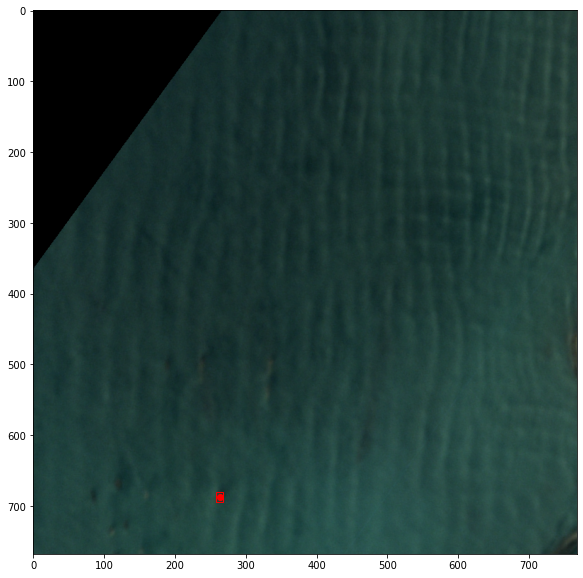

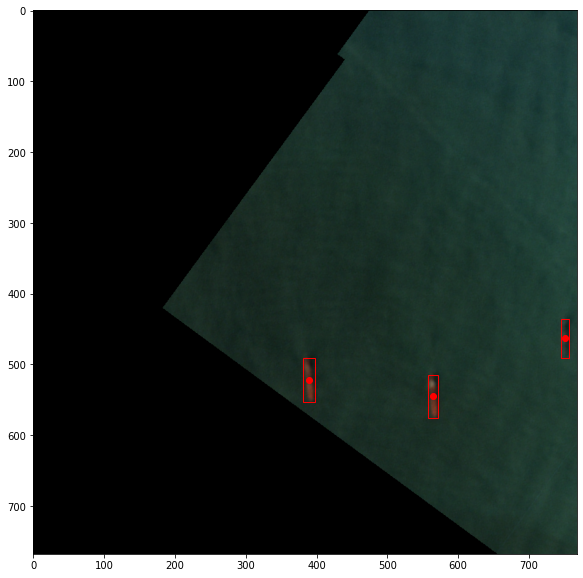

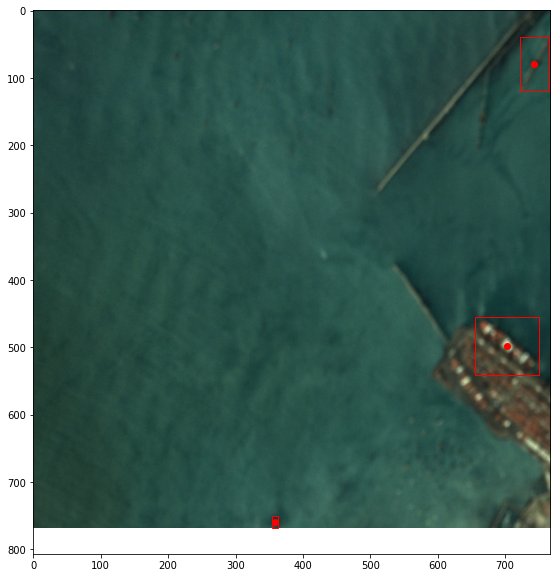

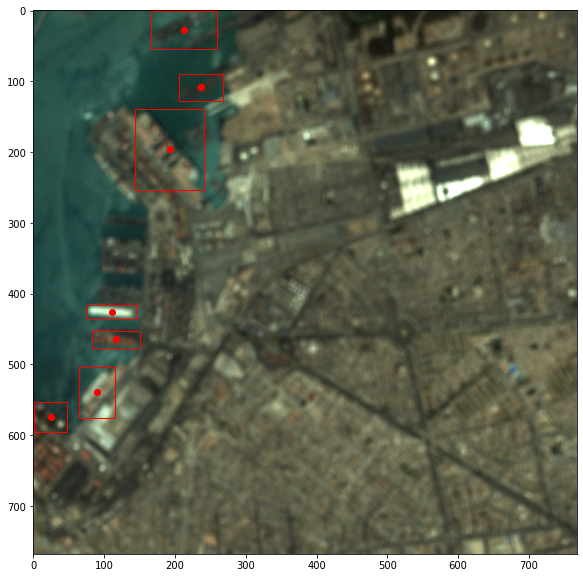

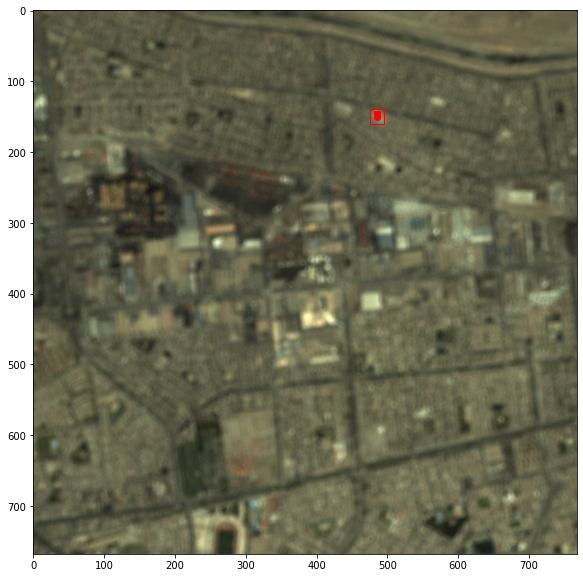

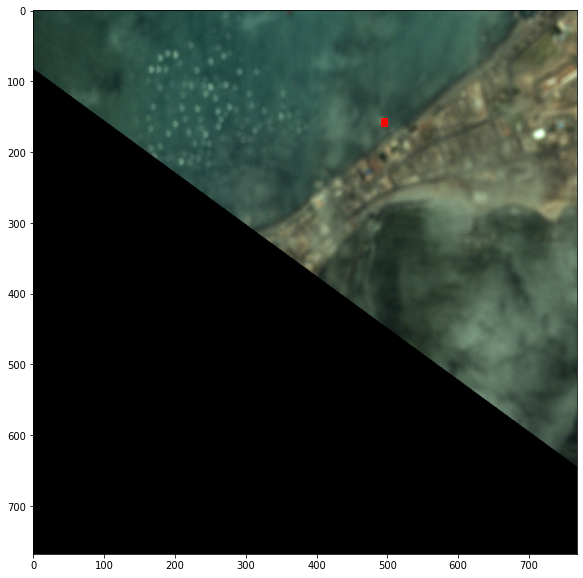

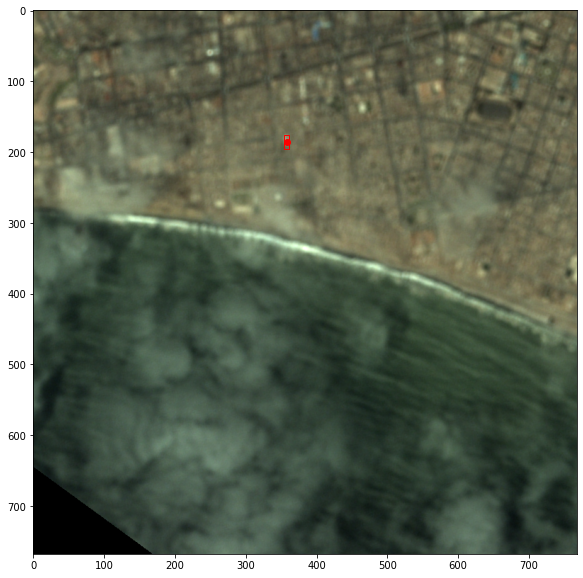

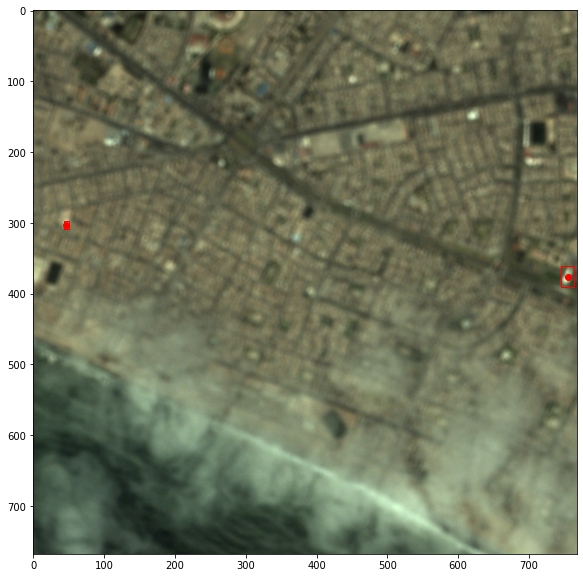

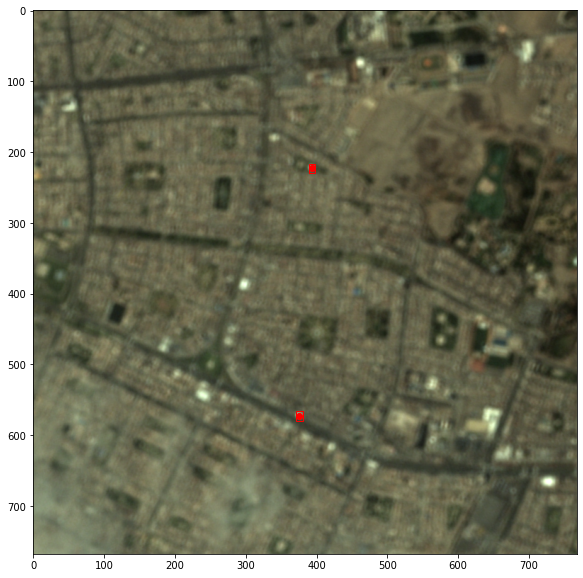

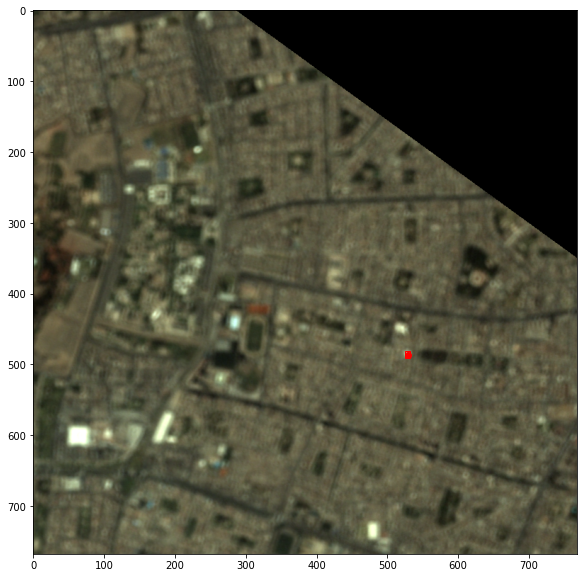

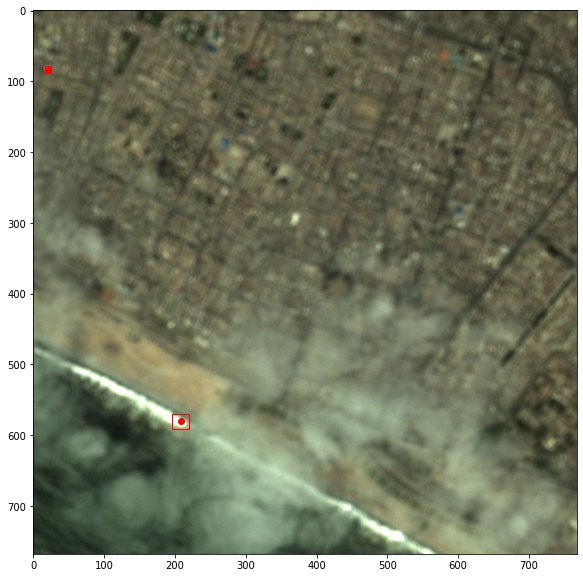

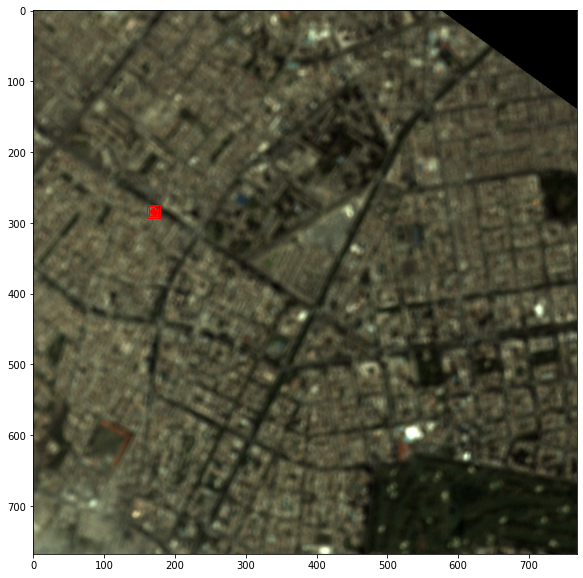

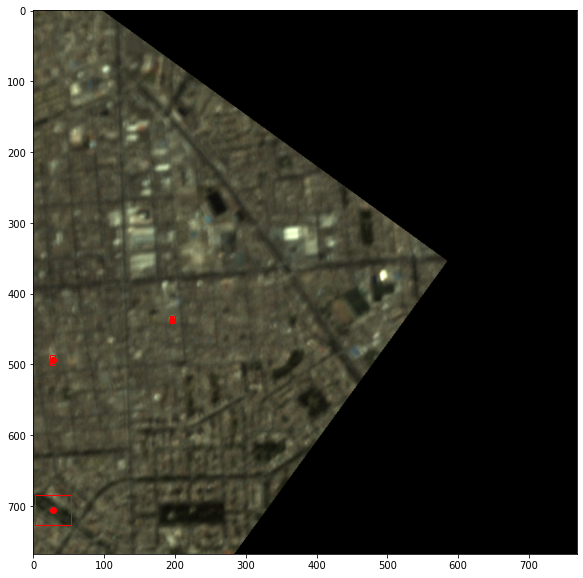

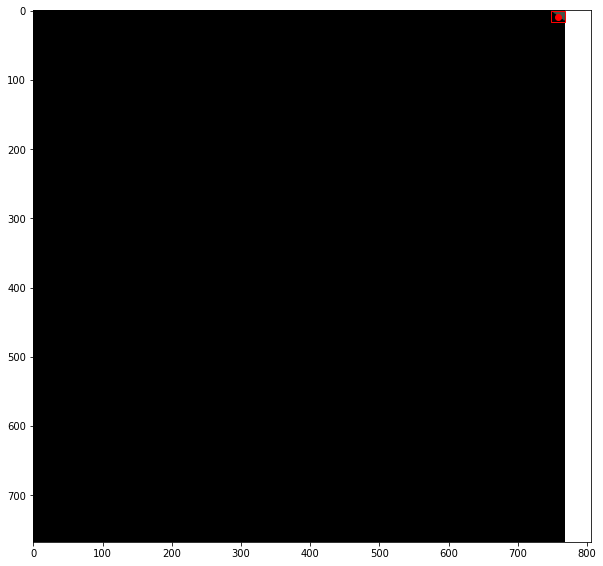

In [21]:
if __name__ == '__main__':
  thresh=0.5
  dirpath = r'lima/2a2ca315-88af-4c4f-be1d-befdab5ce7fa/PSScene4Band/'
  aoi = r'/content/peru_callao.json'
  imgs = prep_imgs(dirpath, BUCKET_NAME, (768, 768, 3), aoi=None, id_start_idx=55, id_end_idx=-18)
  rows = []
  model.eval()
  for img, item_id, subsample_id, (xoff, a, b, yoff, d, e), transform in imgs:
    # Label the image
    image = F.to_tensor(img)
    with torch.no_grad():
      try:
        prediction = model([(image).to(device)])
      except RuntimeError:
        continue
    # Add data to df list
    new_rows = process_outputs(prediction, item_id, subsample_id, 
                               (xoff, a, b, yoff, d, e), transform,
                               thresh=thresh)
    if new_rows is not None:
      plot_bbox(prediction, img, thresh=thresh)
      rows += new_rows
  df = make_df(rows)

In [17]:
rows

[{'area': 1138.2483623921871,
  'bounding_box': array([258.37918, 680.2417 , 267.45547, 694.176  ], dtype=float32),
  'datetime': datetime.datetime(2016, 12, 4, 18, 19, 9),
  'item_id': '20161204_181909_0d06',
  'latitude': -77.17831957063828,
  'longitude': -12.024195253227578,
  'major_length': 41.802978515625,
  'minor_length': 27.2288818359375,
  'probability': 0.83520705,
  'target_id': '20161204_181909_0d06_1_1_0'},
 {'area': 8301.935554593801,
  'bounding_box': array([557.0476 , 514.41473, 572.1301 , 575.5741 ], dtype=float32),
  'datetime': datetime.datetime(2016, 12, 4, 18, 19, 9),
  'item_id': '20161204_181909_0d06',
  'latitude': -77.16998030250474,
  'longitude': -12.020404426343296,
  'major_length': 183.47808837890625,
  'minor_length': 45.24755859375,
  'probability': 0.99922144,
  'target_id': '20161204_181909_0d06_2_0_0'},
 {'area': 9014.599753908813,
  'bounding_box': array([381.48062, 490.81268, 397.41336, 553.67834], dtype=float32),
  'datetime': datetime.datetime(2

In [18]:
df


target_id  ... minor_length
0   20161204_181909_0d06_1_1_0  ...    27.228882
1   20161204_181909_0d06_2_0_0  ...    45.247559
2   20161204_181909_0d06_2_0_1  ...    47.798218
3   20161204_181909_0d06_2_0_2  ...    32.226013
4   20161204_181909_0d06_2_1_0  ...   254.799500
5   20161204_181909_0d06_2_1_1  ...    28.226624
6   20161204_181909_0d06_2_1_2  ...   130.054504
7   20161204_181909_0d06_2_2_0  ...    74.423126
8   20161204_181909_0d06_2_2_1  ...   126.070679
9   20161204_181909_0d06_2_2_2  ...   153.075417
10  20161204_181909_0d06_2_2_3  ...   116.277878
11  20161204_181909_0d06_2_2_4  ...   160.201904
12  20161204_181909_0d06_2_2_5  ...    59.779358
13  20161204_181909_0d06_2_2_6  ...   293.762787
14  20161204_181909_0d06_2_3_0  ...    26.854797
15  20161204_181909_0d06_2_3_1  ...    57.187775
16  20161204_181909_0d06_3_1_0  ...    29.163574
17  20161204_181909_0d06_3_2_0  ...    20.105164
18  20161204_181909_0d06_3_3_0  ...    20.553532
19  20161204_181909_0d06_3_3_1  ...    54.463806
20  20161204_181909_0d06_3_4_0  ...    29.407928
21  20161204_181909_0d06_3_4_1  ...    28.836090
22  20161204_181909_0d06_3_5_0  ...    20.308044
23  20161204_181909_0d06_4_5_0  ...    24.027122
24  20161204_181909_0d06_4_5_1  ...    63.721069
25  20161204_181909_0d06_4_6_0  ...    37.044846
26  20161204_181909_0d06_4_6_1  ...    55.343262
27  20161204_181909_0d06_5_8_0  ...   126.126892
28  20161204_181909_0d06_5_8_1  ...    22.411680
29  20161204_181909_0d06_5_8_2  ...    20.180557
30  20161204_181909_0d06_6_4_0  ...    46.208510

[31 rows x 10 columns]